# DS 1 - LABORATORIO 05

### Juan Lorthiois       -  18771
### Roberto Castillo    -  18546
### Alexis Estrada       -  

#### Incisos 1 a 3:

A continuacion se importan los datos, y se inicia con la limpieza de los mismos en preparación apra el EDA y la aplicacion del agoritmo clasificador.

#### Importacion de librerías e importación de los datos como DataFrame de Pandas

In [1]:
# Importando librerias

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np
import re

from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rssto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rssto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Importando los datos
Df = pd.read_csv("train.csv")

In [3]:
Df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
Df.isna().sum()  #encontrar columnas que tienen Nas.

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
Df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


### Ideas preliminares:

Acabamos de ver que hay Nas, sin embargo la mayorí se concentran en a variable "location". Antes de decidir cómo resolver este inconveniente, se trabajará primero en limpiar los "tweets" mostrados en la variable "text". Posteriormente a este data cleaning, se procederá a decidir si se preservan o no las variables "location" y "keyword".

#### Limpieza de Tweets

In [6]:
#preparamos una funcion que se encargue de limpiar cada tweet

def Tweet_prep(linea):
    
    linea = linea.lower() #poner todo en minusculas
    linea = re.sub(r'http\S+', '', linea) #quitar urls
    linea = re.sub(r"[^a-zA-Z 911]", "", linea) #quitar cualquier cosa que no sean letras o el 911 (tel de emergencias en USA)
    linea = re.sub(' +', ' ',linea) #eliminando cualquier espacio doble o más
    tokens= word_tokenize(linea) #Separamos el String en sus distintas palabras y las ingresamos a un listado de 'Tokens'.
    nuevos_tokens = []
    for i in tokens:
        if i not in stop_words:
            nuevos_tokens.append(i)
    tokens = nuevos_tokens
    
    return tokens

In [7]:
Tweets_listos = [Tweet_prep(linea) for linea in Df.loc[:, 'text']]  #La lista de listas de tweets listos para ser reasignados al Df

In [8]:
len(Df.loc[:, 'text']) #Verificando que las listas tengan el mismo tamaño

7613

In [9]:
len(Tweets_listos)

7613

In [10]:
for i in range(0, len(Tweets_listos)):    #Agregamos las listas de palabras procesadas y listas para su analisis
    Df.at[i, 'text'] = Tweets_listos[i]

In [11]:
Df.head(10)  #listo el Df con los tweets procesados!

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[1, people, receive, wildfires, evacuation, or...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1
5,8,NaN,NaN,"[rockyfire, update, california, hwy, closed, d...",1
6,10,NaN,NaN,"[flood, disaster, heavy, rain, causes, flash, ...",1
7,13,NaN,NaN,"[im, top, hill, see, fire, woods]",1
8,14,NaN,NaN,"[theres, emergency, evacuation, happening, bui...",1
9,15,NaN,NaN,"[im, afraid, tornado, coming, area]",1


#### Frecuencias de palabras y bigramas y trigramas

A continuacion evaluamos las palabras mas frecuentes en el Df general, pero tambien diferenciando entre tweets que se refieren a desastres reales y los que no.

Además, para el análisis en bigramas y trigramas procedemos de manera similar a lo indicado en la pagina: https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5

In [12]:
#Separamos el dataframe en desastres reales y falsos para uso futuro

criterio = Df['target'] == 0

Df_no_desastres = Df[criterio]

Df_solo_desastres = Df[~criterio]


In [13]:
#Ahora contamos la ocurrencia de palabras en el Df, Df_no_desastres, y Df_solo_desastres

Frecuencias_Df = pd.value_counts(np.hstack(Df['text']))
Frecuencias_Df_no_desastres = pd.value_counts(np.hstack(Df_no_desastres['text']))
Frecuencias_Df_solo_desastres = pd.value_counts(np.hstack(Df_solo_desastres['text']))

In [14]:
Frecuencias_Df_solo_desastres

1             295
fire          179
news          133
via           121
disaster      116
             ... 
riveeeeeer      1
iiii            1
swollen         1
idiots          1
flip            1
Length: 8903, dtype: int64

In [15]:
Frecuencias_Df_no_desastres

like                252
im                  245
1                   216
amp                 193
new                 170
                   ... 
dealing               1
surgery               1
knife                 1
improvement           1
explodingkittens      1
Length: 12094, dtype: int64

### Analisis Exploratorio

In [16]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

#### Frecuencia de las palabras en los tweets

In [17]:
Frecuencias_Df

1                  511
like               344
im                 302
amp                299
fire               250
                  ... 
windowgatribble      1
contrasts            1
foreboding           1
expansive            1
symptoms             1
Length: 17139, dtype: int64


#### Nube de palabras

El dataset completo

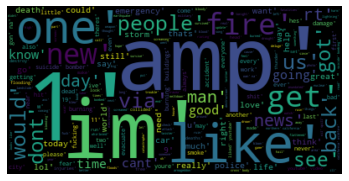

In [18]:
words = list(map(str, Df['text']))

result = ' '.join(words)

wordcloud = WordCloud().generate(result)

#Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("firs.png")


Tweets normales 

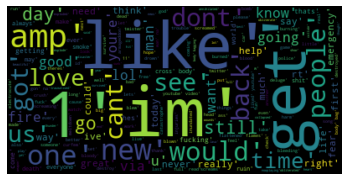

In [19]:
words = list(map(str, Df_no_desastres['text']))

result = ' '.join(words)

wordcloud = WordCloud().generate(result)

#Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("normales.png")

Tweets con desastres

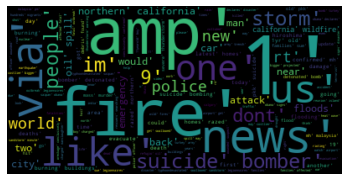

In [20]:
words = list(map(str, Df_solo_desastres['text']))

result = ' '.join(words)

wordcloud = WordCloud().generate(result)

#Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("desastres.png")

#### Histogramas

Tweets normales

In [21]:
# Opcional para establecer un limite (10)
Frecuencias_Df_no_desastres = Frecuencias_Df_no_desastres[:10]

Frecuencias_Df_no_desastres = pd.DataFrame(Frecuencias_Df_no_desastres)

<AxesSubplot:title={'center':'Top 10 Word Frequency'}, xlabel='Word', ylabel='Count'>

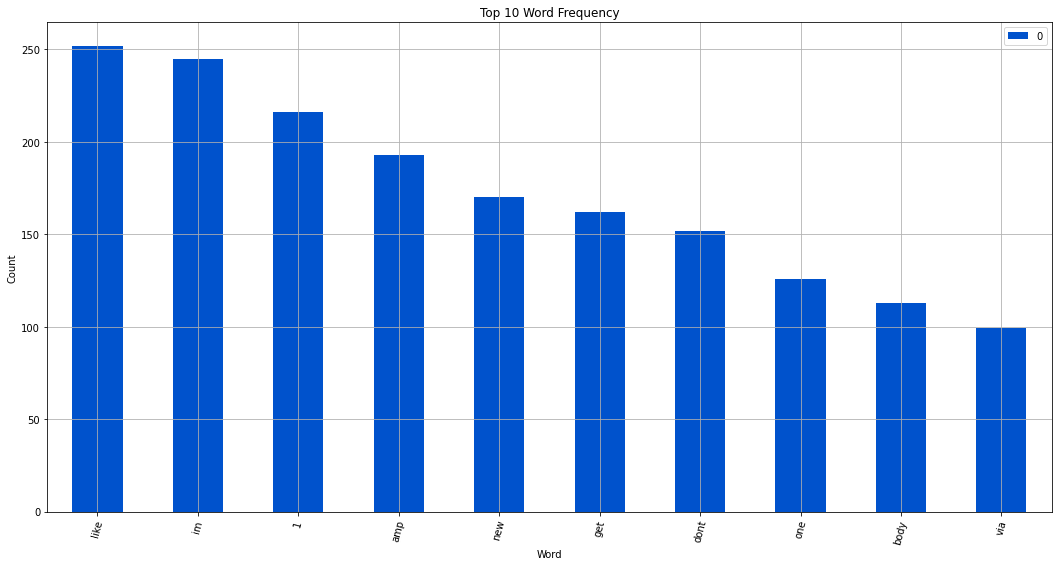

In [22]:
# Grafica de barras
Frecuencias_Df_no_desastres.plot.bar(figsize=(18,9),xlabel="Word",ylabel="Count",title="Top 10 Word Frequency",rot=75,color=["#0052CC"],grid=True)

Tweets con desastres

In [23]:
# Opcional para establecer un limite (10)
Frecuencias_Df_solo_desastres = Frecuencias_Df_solo_desastres[:10]

Frecuencias_Df_solo_desastres = pd.DataFrame(Frecuencias_Df_solo_desastres)

<AxesSubplot:title={'center':'Disaster Top 10 Word Frequency'}, xlabel='Word', ylabel='Count'>

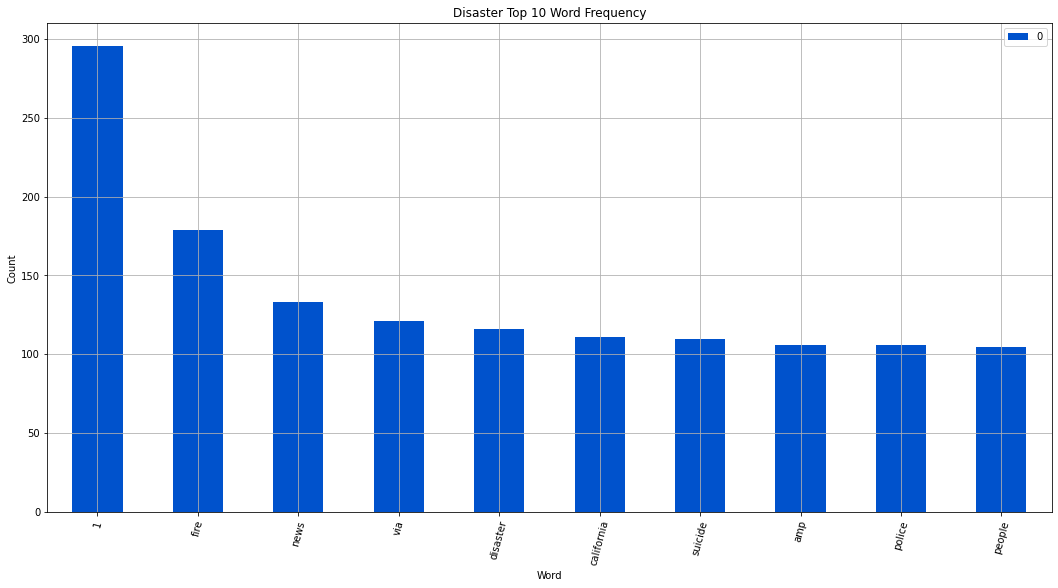

In [24]:
# Grafica de barras
Frecuencias_Df_solo_desastres.plot.bar(figsize=(18,9),xlabel="Word",ylabel="Count",title="Disaster Top 10 Word Frequency",rot=75,color=["#0052CC"],grid=True)

Se clasifican los tweets por positivo, negativo o neutro

In [124]:
from textblob import TextBlob

def useSentimentPolarity(tweet):
    listToString = ' '.join(tweet)
    watchSentiment = TextBlob(listToString)

    if watchSentiment.sentiment.polarity >= 0.05:
        return ['positivo', watchSentiment.sentiment.polarity ]
    elif watchSentiment.sentiment.polarity <= - 0.05:
        return ['negativo', watchSentiment.sentiment.polarity ]
    else:
        return ['neutral', watchSentiment.sentiment.polarity ] 

In [127]:
polarity = []
polarity_value = []
for i in range(0, len(Df)):
    polarity.append(useSentimentPolarity(Df.loc[i, 'text'])[0])
    polarity_value.append(useSentimentPolarity(Df.loc[i, 'text'])[1])

Df['polarity'] = polarity
Df['polarity_value'] = polarity_value
Df

,id,keyword,location,text,target,polarity,polarity_value
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1,neutral,0.000000
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1,positivo,0.100000
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1,negativo,-0.100000
3,6,NaN,NaN,"[1, people, receive, wildfires, evacuation, or...",1,neutral,0.000000
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1,neutral,0.000000
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,"[two, giant, cranes, holding, bridge, collapse...",1,neutral,0.000000
7609,10870,NaN,NaN,"[ariaahrary, thetawniest, control, wild, fires...",1,positivo,0.100000
7610,10871,NaN,NaN,"[m19, 1, utckm, volcano, hawaii]",1,neutral,0.000000
7611,10872,NaN,NaN,"[police, investigating, ebike, collided, car, ...",1,negativo,-0.260417


Histograma con la cantidad de tweets positivos, negativos y neutros.

(array([3928.,    0.,    0.,    0.,    0., 2207.,    0.,    0.,    0.,
        1478.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

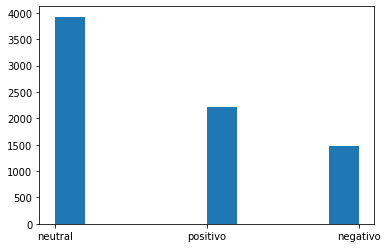

In [128]:
plt.hist(Df['polarity'])

Los 10 tweets más negativos

In [131]:
Df.sort_values(by=['polarity_value']).head(10)

,id,keyword,location,text,target,polarity,polarity_value
426,617,arsonist,ss,"[hif, trick, think, nasty, things]",0,negativo,-1.0
454,657,attack,Freeport IL. USA,"[horrific, attack, wife, muslim, italy, livele...",1,negativo,-1.0
5799,8278,rioting,NaN,"[aelinrhee, group, mascara, smeared, girls, ri...",1,negativo,-1.0
6672,9563,thunder,"South Carolina, USA","[worst, part, seeing, lightning, trying, guess...",0,negativo,-1.0
3557,5083,famine,Massachusetts,"[russia, destroys, food, people, go, hungry, o...",1,negativo,-1.0
7195,10307,weapon,NaN,"[abcnews, nuclear, bomb, terrible, weapon]",1,negativo,-1.0
4849,6908,mass%20murderer,Earth-616,"[creelyou, must, think, im, real, moron, flag,...",0,negativo,-1.0
501,726,attacked,"Los Angeles, CA","[envw9, nickcocofree, juliedicaro, jdabe, wors...",0,negativo,-1.0
166,241,airplane%20accident,Fashion Heaven. IG: TMId_,"[phone, looks, like, car, ship, airplane, acci...",0,negativo,-1.0
3717,5285,fear,"Thibodaux, LA","[worst, fear]",0,negativo,-1.0


Los 10 tweets más positivos

In [132]:
Df.sort_values(by='polarity_value', ascending=False).head(10)

,id,keyword,location,text,target,polarity,polarity_value
4819,6860,mass%20murder,Los Angeles,"[rt, owenrbroadhurst, rt, juanmthompson, hour,...",1,positivo,1.0
5116,7296,nuclear%20reactor,NaN,"[check, awesome, profile, ges, swimming, robot...",0,positivo,1.0
6660,9547,threat,NaN,"[end, australias, best, burger, via, newscomauhq]",0,positivo,1.0
128,184,aftershock,304,"[remembering, going, die, best, way, know, avo...",0,positivo,1.0
2046,2936,danger,Atlanta Georgia,"[nuggets, fettilootch, slanglucci, oppressions...",0,positivo,1.0
6440,9215,suicide%20bombing,NaN,"[malik, saadthe, best, police, officer, produc...",1,positivo,1.0
5298,7568,outbreak,"Stockholm, Sweden","[senatemajldr, lets, try, best, prevent, anoth...",1,positivo,1.0
47,67,ablaze,NaN,"[building, perfect, tracklist, life, leave, st...",0,positivo,1.0
413,599,arsonist,Atlanta,"[nowplaying, arsonist, mc, impressed, arsonist...",0,positivo,1.0
6291,8987,storm,Santiago de Chile,"[doves, storm, greatest, denier, electric, pro...",1,positivo,1.0


### Entrenamiento del modelo